<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Data-prep" data-toc-modified-id="Data-prep-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data prep</a></span></li><li><span><a href="#KNN-models" data-toc-modified-id="KNN-models-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>KNN models</a></span></li><li><span><a href="#SVD-models" data-toc-modified-id="SVD-models-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>SVD models</a></span></li><li><span><a href="#NMF-models" data-toc-modified-id="NMF-models-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>NMF models</a></span></li><li><span><a href="#SlopeOne-model" data-toc-modified-id="SlopeOne-model-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>SlopeOne model</a></span></li><li><span><a href="#Co-cluster-model" data-toc-modified-id="Co-cluster-model-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Co-cluster model</a></span></li></ul></div>

# Introduction

This notebook contains code for building a recommendation system based on data about people's preferences for musical artists. The data comes originally from [Last.fm](http://lastfm.com) via [Grouplens.org](https://grouplens.org/datasets/hetrec-2011/). 

Unlike many datasets used in recommendation systems, this one does not record users' ratings of items on a discrete scale (e.g., a 5-point scale). Instead, this dataset records how many times a user listened to a given artist. This value can range from 1 up to several hundred thousand. RMSE, the measure I use to evaluate model performance here, will thus be in units of "listens." 

My general approach is first to try a selection of KNN models, and then to compare the more sophisticated SVD++ model, known for its strong performance in the Netflix competition. Inspiration for this project came from [this blog post](https://blog.cambridgespark.com/tutorial-practical-introduction-to-recommender-systems-dbe22848392b).

# Data prep

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import surprise
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV, cross_validate
from surprise.prediction_algorithms import knns
from surprise.similarities import cosine, msd, pearson
from surprise import accuracy

In [2]:
# Read in data
df = pd.read_table("user_artists.dat", sep='\t', header=0)
df.head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


In [3]:
# View distribution of 'weight' values
df['weight'].describe()

count     92834.00000
mean        745.24393
std        3751.32208
min           1.00000
25%         107.00000
50%         260.00000
75%         614.00000
max      352698.00000
Name: weight, dtype: float64

In [18]:
np.percentile(df['weight'], 95)

2328.0

In [19]:
df_trim = df[df['weight'] <= np.percentile(df['weight'], 95)]
df_trim['weight'].describe()

count    88193.000000
mean       402.631105
std        446.964515
min          1.000000
25%        101.000000
50%        240.000000
75%        530.000000
max       2328.000000
Name: weight, dtype: float64

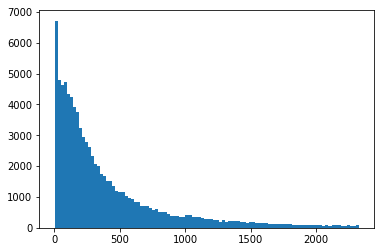

In [20]:
plt.hist(df_trim['weight'], bins=100);

In [21]:
# Get min and max of 'weight'
min_weight = min(df_trim['weight'])
max_weight = max(df_trim['weight'])

In [22]:
# Initialize Reader object
reader = surprise.Reader(rating_scale = (min_weight, max_weight))

In [23]:
# Parse the dataset
data = surprise.Dataset.load_from_df(df, reader)

In [24]:
# Split data into training and test sets
trainset, testset = train_test_split(data, test_size=0.2)

In [25]:
# View counts of users and items (artists) to see which is lower
print('Number of users:', trainset.n_users)
print('Number of artists:', trainset.n_items)

Number of users: 1889
Number of artists: 15351


# KNN models

In [26]:
# Try out a KNNBasic model
cos_sim_params = {'name':'cosine', 'user_based':True}

basic = knns.KNNBasic(sim_options=cos_sim_params)
basic.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [27]:
# Evaluate the KNNBasic model
basic_pred = basic.test(testset)
print(accuracy.rmse(basic_pred))

RMSE: 4236.0426
4236.04260094406


In [28]:
# Try same model, this time with Pearson similarity
pear_sim_params = {'name':'pearson', 'user_based':True}

basic_pear = knns.KNNBasic(sim_options=pear_sim_params)
basic_pear.fit(trainset)

basic_pear_pred = basic_pear.test(testset)
print(accuracy.rmse(basic_pear_pred))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 4233.0307
4233.030664214467


In [68]:
# Try same model, this time with Mean Squared Difference similarity
msd_sim_params = {'name':'msd', 'user_based':True}

basic_msd = knns.KNNBasic(sim_options=msd_sim_params)
basic_msd.fit(trainset)

basic_msd_pred = basic_msd.test(testset)
print(accuracy.rmse(basic_msd_pred))

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 2923.5293
2923.5293363502374


Pearson similarity performed better than the other two metrics, so I'll proceed to use Pearson similarity to evaluate the various KNN models.

In [75]:
# Try a KNNWithMeans model
knn_means = knns.KNNWithMeans(sim_options=pear_sim_params)
knn_means.fit(trainset)

knn_means_pred = knn_means.test(testset)
print(accuracy.rmse(knn_means_pred))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 2844.2060
2844.206028229536


In [79]:
# Try a KNNWithZScore model
knn_z = knns.KNNWithZScore(sim_options=pear_sim_params)
knn_z.fit(trainset)

knn_z_pred = knn_z.test(testset)
print(accuracy.rmse(knn_z_pred))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 2831.1615
2831.161528114996


In [83]:
# Try a KNNBaseline model
knn_base = knns.KNNBaseline(sim_options=pear_sim_params)
knn_base.fit(trainset)

knn_base_pred = knn_base.test(testset)
print(accuracy.rmse(knn_base_pred))

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 2837.0416
2837.041647253123


RMSE: 2921.1950
RMSE: 2844.2060
RMSE: 2831.1615
RMSE: 2837.0416


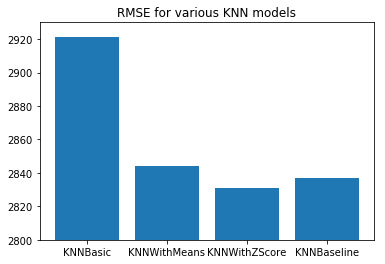

In [84]:
# Visualize RMSE for the three types of models
basic_acc = accuracy.rmse(basic_pred)
means_acc = accuracy.rmse(knn_means_pred)
z_acc = accuracy.rmse(knn_z_pred)
base_acc = accuracy.rmse(knn_base_pred)

rmses = [basic_acc, means_acc, z_acc, base_acc]
names = ['KNNBasic', 'KNNWithMeans', 'KNNWithZScore', 'KNNBaseline']

plt.bar(names, rmses)
plt.ylim([2800, 2930])
plt.title('RMSE for various KNN models')
plt.show();


# SVD models

In [86]:
# Fit a baseline SVD model
svd_1 = surprise.SVD()
svd_1.fit(trainset)

svd_1_pred = svd_1.test(testset)
print(accuracy.rmse(svd_1_pred))

RMSE: 3326.6061
3326.6060520122237


In [ ]:
# Use a grid search to tune hyperparameters
params = {'lr_all':[0.001, 0.01],
          'reg_all': [0.1, 0.5]}

grid_svd = GridSearchCV(surprise.SVDpp, params, measures=['rmse', 'mae'], cv=3)
grid_svd.fit(data)
grid_svd_pred = grid_svd.test(test_set)

print(grid_svd.best_params['rmse'])
print(accuracy.rmse(grid_svd_pred))

In [85]:
# Fit a baseline SVD++ model
svdpp_1 = surprise.SVDpp()
svdpp_1.fit(trainset)

svdpp_1_pred = svdpp_1.test(testset)
print(accuracy.rmse(svdpp_1_pred))

RMSE: 3326.6061
3326.6060520122237


In [87]:
# Use a grid search to tune hyperparameters
params = {'lr_all':[0.001, 0.01],
          'reg_all': [0.1, 0.5]}

grid_svdpp = GridSearchCV(surprise.SVDpp, params, measures=['rmse', 'mae'], cv=3)
grid_svdpp.fit(data)
grid_svdpp_pred = grid_svdpp.test(testset)

print(grid_svdpp.best_params['rmse'])
print(accuracy.rmse(grid_svdpp_pred))

# NMF models

In [88]:
nmf = surprise.NMF()
nmf.fit(trainset)

nmf_pred = nmf.test(testset)
print(accuracy.rmse(nmf_pred))

RMSE: 3000.2287
3000.2287299618365


In [ ]:
params = {'reg_pu': [100, 200],
          'reg_qi': [100, 200],
          'n_factors': [15, 30]}

grid_nmf = GridSearchCV(surprise.NMF, params, measures=['rmse'], cv=3)
grid_nmf.fit(data)

print(grid_nmf.best_params['rmse'])

In [108]:
print(grid_nmf.best_score)

{'rmse': 3671.9925162150207}


# SlopeOne model

In [109]:
slope = surprise.SlopeOne()
slope.fit(trainset)

slope_pred = slope.test(testset)
print(accuracy.rmse(slope_pred))

RMSE: 2831.7504
2831.750375843168


# Co-cluster model

In [110]:
clus = surprise.CoClustering()
clus.fit(trainset)

clus_pred = clus.test(testset)
print(accuracy.rmse(clus_pred))

RMSE: 2843.1831
2843.183114847419
